<img src="../imgs/head.png" style="width:1000px;">

# <center> Detección de Hate Speech en Twitter </center>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


%matplotlib inline

## <center> Dataset </center>

In [10]:
d = pd.read_csv("../data/labeled_data.csv")
pd.set_option('display.max_colwidth', -1)
print(d.shape)
d.head()

(34380, 7)


,Unnamed: 0,count,hate_speech,offensive_language,neither,clase,tweet
0,0.0,3.0,0.0,0.0,3.0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1.0,3.0,0.0,3.0,0.0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2.0,3.0,0.0,3.0,0.0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3.0,3.0,0.0,2.0,1.0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4.0,6.0,0.0,6.0,0.0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


### Identificación de clases

In [11]:
hateSpeech = d[d.clase == 0].shape[0]
off = d[d.clase == 1].shape[0]
net = d[d.clase == 2].shape[0]
print("Hate Speech", hateSpeech,"\nOffensive", off, "\nNeither", net)

Hate Speech 3829 
Offensive 19144 
Neither 11407


### Balanceo del dataset

In [12]:
hateSpeechd = d[d.clase == 0]
offd = d[d.clase == 1].reindex(np.random.permutation(d[d.clase == 1].index))
offtest = offd[5000:9000]
offd = offd[0:4000]
netd = d[d.clase == 2].reindex(np.random.permutation(d[d.clase == 2].index))
nettest = netd[5000:9000]
netd = netd[0:4000]

In [13]:
df = pd.DataFrame()
dfTest =  pd.DataFrame()
a=[hateSpeechd, offd, netd]
b = [hateSpeechd, offd, netd, offtest, nettest]
df = pd.concat(a, ignore_index=True)
dfTest=pd.concat(b, ignore_index=True)

In [16]:
df = df.reindex(np.random.permutation(df.index))
df[['clase','tweet']].head()


,clase,tweet
10202,2,With my coon dawgs Drevon &amp; Ayub
2369,0,@fdGhtP54 @Nicestguyontwit @NotKrieg see this is why we need to kill all fat people
3800,0,#MusicIsTheKey #IcePrince Open Voice (LGBTQ) :: NYC Woman Files Lawsuit Claiming Cop Called Her Gay Slur; Dyke... https://t.co/udgClGHoBu
2693,0,@Autumnchild68 @HillaryforNV stupid nigger
11715,2,weight loss tips: get a job at Apple doing back of house for Christmas and you'll drop 2 sizes and no clothes will fit you that you own �_��_崁���_��_崁��


## <center> Preprocesamiento de los datos </center>

<img src="../imgs/preprocessing.png" style="width:800px;">

### Eliminación de ruido

In [17]:
##preprocesamiento del dataset original
clean1 = df["tweet"].str.replace((r'@[\w]*'), '')
clean2 = clean1.str.replace(r'RT', '')
clean = clean2.str.replace(r'[^a-zA-Z +^'']', '')


##preprocesamiento del dataset modificado
clean1T = dfTest["tweet"].str.replace((r'@[\w]*'), '')
clean2T = clean1T.str.replace(r'RT', '')
cleanTweetsT = clean2T.str.replace(r'[^a-zA-Z +^'']', '')

### Tokenización

La tokenización es el paso en el que se divide cadenas de texto más largas en piezas más pequeñas o tokens. 

In [21]:
tokens = []
tokens2 = []
for i in clean:
    tokens.append(nltk.word_tokenize(i))

for i in cleanTweetsT:
    tokens2.append(nltk.word_tokenize(i))
    

### Eliminación de stopwords

In [23]:
stop_words= set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

lower_case = [[x.casefold() for x in sublst] for sublst in tokens]
cleanTweets = [[wordsub for wordsub in word if wordsub not in stop_words] for word in lower_case]


In [26]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))

### CountVectorizer

In [27]:
vectorized_data = count_vectorizer.fit_transform(clean)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))


vectorized_dataT = count_vectorizer.fit_transform(cleanTweetsT)
indexed_dataT = hstack((np.array(range(0,vectorized_dataT.shape[0]))[:,None], vectorized_dataT))
targetsT = dfTest["clase"]
indexed_dataT.shape

(19829, 148618)

### Separamos el dataset original

In [29]:
from sklearn.model_selection import train_test_split
targets = df["clase"]
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

### Separamos el dataset modificado

In [13]:
from sklearn.model_selection import train_test_split
targetsT = dfTest["clase"][0:11828]
data_train2, data_test2, targets_train2, targets_test2 = train_test_split(indexed_dataT.tocsr()[0:11828,:], targetsT, test_size=0.4, random_state=0)
data_train_index2 = data_train2[:,0]
data_train2 = data_train2[:,1:]
data_test_index2 = data_test2[:,0]
data_test2 = data_test2[:,1:]

## OneVsRestClassifier 
### SVC

In [38]:
clf = OneVsRestClassifier(svm.SVC(probability=True, kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

In [39]:
print("test accuracy  %.5f "%(clf.score(data_train, targets_train)))
print("test accuracy  %.5f "%(clf.score(data_test, targets_test)))

test accuracy  0.99901 
test accuracy  0.85165 


### MultinomialNB

In [44]:
from sklearn.naive_bayes import MultinomialNB
clf2 = OneVsRestClassifier(MultinomialNB(alpha=5))
clf2.fit(data_train, targets_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=5, class_prior=None, fit_prior=True),
          n_jobs=1)

In [45]:
clf2.score(data_test, targets_test)

0.8193153000845309

In [46]:
clf2.score(data_train, targets_train)

0.9429336339298295

## Probabilidad de pertenecer a una clase

In [365]:
indx = np.random.randint(df.shape[0], size=10)
rand = []
clases = []
for i in indx:
    rand.append(clean[i])
    clases.append(df['clase'][i])
print(rand)

['  Charlie Strong took the longhorn logos off his players helmets They have to earn it back httptcoHvNUJTSs Sport', 'niggers are so fucking mad just cause the shooter was a sand nigger kebab go take your anger out on them', '  I hate you sidelines hoes yall got so much courage ', 'paper ova pussy', 'Nah fam Miss Mexico won for leaving that dumb superficial contest thats runned by that racist old piece of white trash Donald trump', '        sweet dreams Alan', 'Only on the rd ep of AHSHotel is there a reason for all the guys looking alike Thought they were gonna be bros but no', 'Beautiful church converted to a book store  Maastricht Netherlands httpstcopGWLzlCvO', 'me complains about suburban white girlssuburban white girl youre a bitchme ok u literally just proved my point', 'We hate niggers we hate faggots and we hate spicskkk rally']


In [50]:
try_tweets = count_vectorizer.transform(rand)
pred = clf.predict_proba(try_tweets)
np.set_printoptions(suppress=True)
pred

array([[0.34912587, 0.08431585, 0.56655828],
       [0.05850134, 0.93834512, 0.00315354],
       [0.06331167, 0.0654149 , 0.87127343],
       [0.09800858, 0.03237168, 0.86961974],
       [0.92178406, 0.07376009, 0.00445586],
       [0.04341488, 0.92875155, 0.02783357],
       [0.89918281, 0.07193299, 0.0288842 ],
       [0.16501035, 0.25542668, 0.57956298],
       [0.03842045, 0.93189858, 0.02968098],
       [0.05633224, 0.93011001, 0.01355775]])

In [51]:
targets_predic2= pd.Series(pred2)

## Resultados obtenidos vs esperados

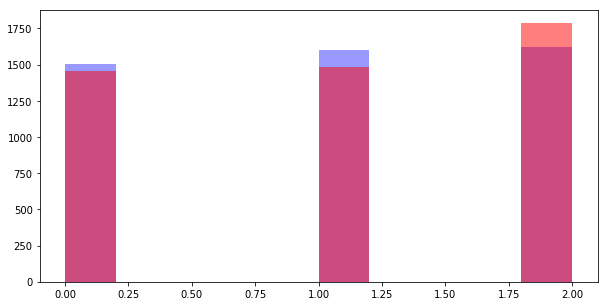

In [368]:

plt.figure(figsize=(10, 5))

targets_test.hist(alpha=0.4, color='b')
targets_predic2.hist(alpha=0.5, color='r')
plt.grid(b=None)
plt.show()

### Cross validation

### RandomForestClassifier

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [25]:
est = RandomForestClassifier(n_estimators=100)
s = cross_val_score(est,indexed_data, targets, cv=KFold(3, shuffle=True), scoring=make_scorer(accuracy_score))
print(s)
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

[0.84757799 0.84098402 0.83439006]
accuracy 0.841 (+/- 0.00538)


In [46]:
est = MultinomialNB(alpha=1.3)
s = cross_val_score(est,indexed_data, targets, cv=KFold(15, shuffle=True), scoring=make_scorer(accuracy_score))
print(s)
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

[0.78453739 0.77946768 0.76806084 0.75918885 0.75158428 0.7756654
 0.7617237  0.78200253 0.77439797 0.76649746 0.78426396 0.76649746
 0.75507614 0.79441624 0.77791878]
accuracy 0.772 (+/- 0.01174)


In [51]:
from sklearn.svm import SVC
est = SVC()
s = cross_val_score(est,indexed_data, targets, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print(s)
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

[0.3262891  0.33896872 0.35418428 0.32882502 0.34742181 0.33981403
 0.33474218 0.32967033 0.34404057 0.33756345]
accuracy 0.338 (+/- 0.00832)


In [275]:
est = SVC()
est.fit(data_train2,targets_train2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
clf.score(data_train2,targets_train2)
clf.score(data_test2,targets_test2)

NameError: name 'data_train2' is not defined

In [276]:
indrand = list(np.random.randint(11829,19829,1000))

In [277]:
est.score(indexed_dataT.tocsr()[indrand,:-1], dfTest["clase"][indrand])

0.49

In [232]:
indrand = list(np.random.randint(11829,19829,1000))

In [233]:
est.score(indexed_dataT.tocsr()[indrand,:-1], dfTest["clase"][indrand])

0.525

## NAIVE BAYES

In [27]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

text_clf=MultinomialNB(fit_prior=True,class_prior=[0.338,0.338,0.29])


In [226]:
def tpr(est,X,y):
    p = est.predict(X)
    return np.mean (p[y==1] == y[y==1])

def tnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==0] == y[y==0])
def nnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==2] == y[y==2])

In [227]:

s = cross_val_score(text_clf,indexed_data,targets, cv=KFold(5,shuffle=True) , scoring=make_scorer(accuracy_score))
print("accuracy %.4f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(text_clf,indexed_data,targets, cv=KFold(5,shuffle=True), scoring=tpr)
print("tpr      %.4f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(text_clf,indexed_data,targets, cv=KFold(5,shuffle=True), scoring=tnr)
print("tnr      %.4f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(text_clf,indexed_data,targets, cv=KFold(5,shuffle=True), scoring=nnr)
print("tnr      %.4f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.9181 (+/- 0.02448)
tpr      0.9153 (+/- 0.01411)
tnr      0.8824 (+/- 0.01028)
tnr      0.9649 (+/- 0.01404)


## RandomForest

In [229]:
text_clf=RandomForestClassifier()

In [230]:

s = cross_val_score(text_clf,indexed_data,targets, cv=KFold(5,shuffle=True) , scoring=make_scorer(accuracy_score))
print("accuracy %.4f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(text_clf,indexed_data,targets, cv=KFold(5,shuffle=True), scoring=tpr)
print("tpr      %.4f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(text_clf,indexed_data,targets, cv=KFold(5,shuffle=True), scoring=tnr)
print("tnr      %.4f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(text_clf,indexed_data,targets, cv=KFold(5,shuffle=True), scoring=nnr)
print("tnr      %.4f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.9234 (+/- 0.01056)
tpr      0.9050 (+/- 0.03011)
tnr      0.8729 (+/- 0.02514)
tnr      0.9713 (+/- 0.00780)


## Redes neuronales

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
input_dim = data_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

W0717 05:46:16.513685 140169610901312 deprecation.py:506] From /home/liceth/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

W0717 05:47:38.596102 140169610901312 deprecation.py:323] From /home/liceth/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                961150    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 961,161
Trainable params: 961,161
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(data_train, targets_train,epochs=15,verbose=False,validation_data=(data_test, targets_test),batch_size=10)

In [59]:
loss, accuracy = model.evaluate(data_train, targets_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, targets_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5111
Testing Accuracy:  0.4303


In [60]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

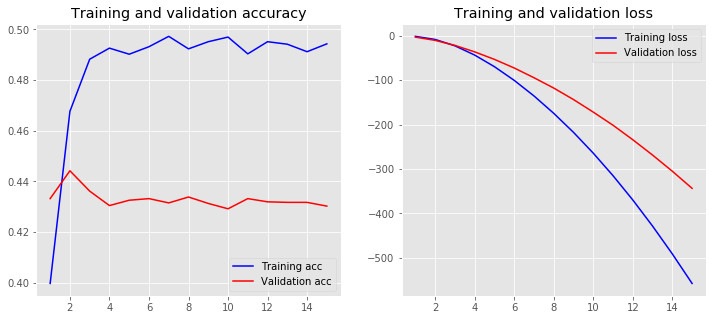

In [61]:
plot_history(history)

### Frecuencia de palabras para cada clase

In [302]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [347]:
wordshate=df[(df.clase == 0)][['preprocessed']].apply(count_words)['preprocessed'].most_common(20)
wordsoff=df[(df.clase == 1)][['preprocessed']].apply(count_words)['preprocessed'].most_common(20)
wordsneit=df[(df.clase == 2)][['preprocessed']].apply(count_words)['preprocessed'].most_common(20)

In [415]:
w=np.array(wordshate)[:,0]
c=np.array(wordshate)[:,1]

w1=np.array(wordsoff)[:,0]
c1=np.array(wordsoff)[:,1]

w2=np.array(wordsneit)[:,0]
c2=np.array(wordsneit)[:,1]

In [416]:
d = pd.DataFrame({'word': w,
                  'valor': [int(x) for x in c]})
d1 = pd.DataFrame({'word': w1,
                  'valor': [int(x) for x in c1]})
d2 = pd.DataFrame({'word': w2,
                  'valor': [int(x) for x in c2]})


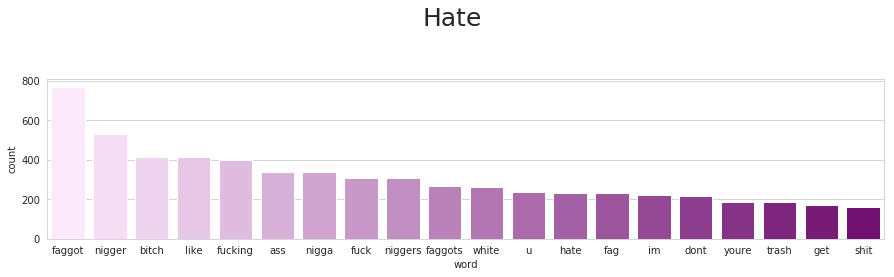

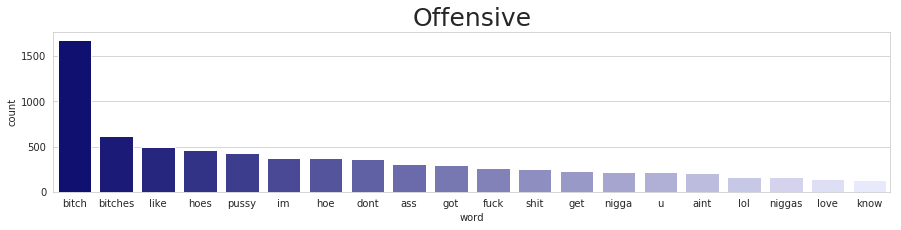

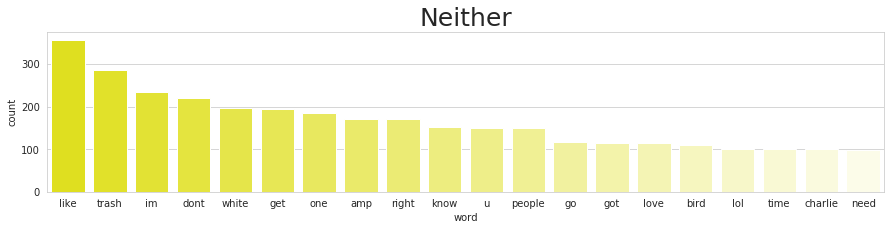

In [451]:
fig = plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
fig.suptitle('Hate', fontsize=25)
ax = sns.barplot(data=d, x= "word", y = "valor", palette= sns.light_palette("purple",n_colors=20, reverse=False))
ax.set(ylabel = 'count')
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(3,1,2)
ax = sns.barplot(data=d1, x= "word", y = "valor",palette=sns.light_palette("navy",n_colors=20, reverse=True))
ax.set(ylabel = 'count')
plt.title("Offensive", fontsize=25)
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(3,1,3)
ax = sns.barplot(data=d2, x= "word", y = "valor",palette=sns.light_palette("yellow",n_colors=20, reverse=True))
ax.set(ylabel = 'count')
plt.title("Neither", fontsize=25)
plt.show()